In [17]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, ConcatDataset
import matplotlib.pyplot as plt
import numpy as np
import time
import sys

print("PyTorch Version:", torch.__version__)
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
sys.stdout.flush()

PyTorch Version: 2.0.1
Using device: cpu


In [18]:
# Hyperparameters and config
# Path to image folders - use both AD and NC when training
# AD = Alzheimer’s disease
# CN = Cognitive Normal
AD_dir = "data/AD_NC/train/AD-parent/"
NC_dir = "data/AD_NC/train/NC-parent/"

image_dir = "imgs/"

batch_size = 128

num_epochs = 10

# Factor to reduce the width and height of the images by
dimension_reduce_factor = 2 # downsample factor of 4

# Original dimensions
original_width = 256
original_height = 240

In [19]:
def downsample_tensor(original: torch.Tensor):
    return transforms.Resize([
        original_height // dimension_reduce_factor, 
        original_width // dimension_reduce_factor
    ],antialias=True)(original)

original.shape torch.Size([128, 3, 240, 256])
batch inputs shape: torch.Size([128, 3, 120, 128])


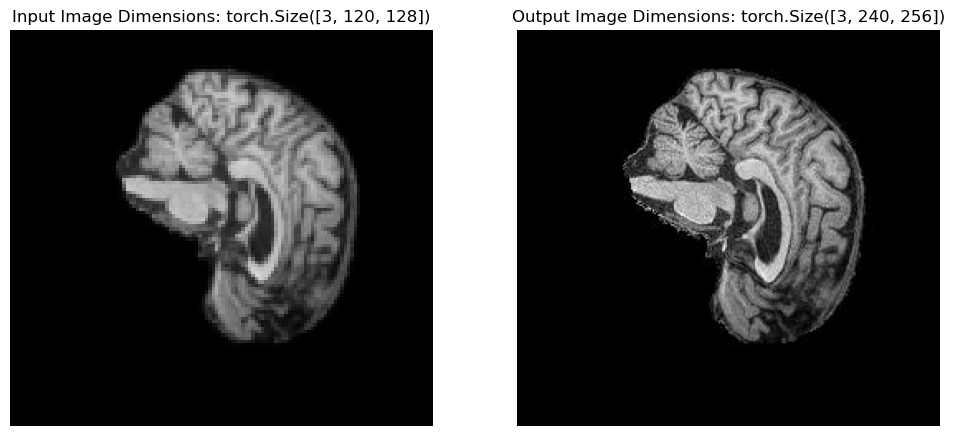

In [20]:
transform = transforms.Compose([
    transforms.ToTensor(),
])

AD_dataset = ImageFolder(root=AD_dir, transform=transform)
NC_dataset = ImageFolder(root=NC_dir, transform=transform)

dataset = ConcatDataset([AD_dataset, NC_dataset])

# Create a data loader to iterate through the dataset
data_loader = DataLoader(dataset=dataset, batch_size=batch_size, shuffle=True)

for original, _ in data_loader:
    print('original.shape', original.shape)

    # Look at the first image
    output = original[0]
    # Downsample to get input
    input = downsample_tensor(output)

    all_inputs = downsample_tensor(original)
    print('batch inputs shape:', all_inputs.shape)
    
    input_dims = input.shape
    output_dims = output.shape
    
    # Display the input image
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(input.permute(1, 2, 0))  # Convert tensor to numpy format (C, H, W) -> (H, W, C)
    plt.title(f"Input Image Dimensions: {input_dims}")
    plt.axis('off')  # Turn off axis labels
    
    # Display the first output image
    plt.subplot(1, 2, 2)
    plt.imshow(torch.clamp(output.permute(1, 2, 0), 0, 1))  # Convert tensor to numpy format (C, H, W) -> (H, W, C)
    plt.title(f"Output Image Dimensions: {output_dims}")
    plt.axis('off') # Turn off axis labels
    
    plt.savefig(image_dir + 'dimensions.png')
    # plt.show()
    
    break  # Stop after the first batch to print/display only the first pair of images

In [21]:
class SuperResolutionModel(nn.Module):
    def __init__(self, upscale_factor=2, channels=3):
        super(SuperResolutionModel, self).__init__()
        
        self.inputs = nn.Sequential(
            nn.Conv2d(channels, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 32, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, channels * (upscale_factor ** 2), kernel_size=3, padding=1),
        )
        
        self.outputs = nn.Sequential(
            nn.PixelShuffle(upscale_factor),
        )

    def forward(self, x):
        x = self.inputs(x)
        x = self.outputs(x)
        return x

In [22]:
# Create an instance of the super-resolution model
model = SuperResolutionModel(upscale_factor=dimension_reduce_factor)

# Test the model with an example input
input_tensor = torch.randn(1, 3, original_height // dimension_reduce_factor, 
        original_width // dimension_reduce_factor)  # Batch size of 1
output_tensor = model(input_tensor)

# Check the shape of the output
print("Input shape:", input_tensor.shape)
print("Output shape:", output_tensor.shape)

Input shape: torch.Size([1, 3, 120, 128])
Output shape: torch.Size([1, 3, 240, 256])


Saved model output to imgs/testoutput.png


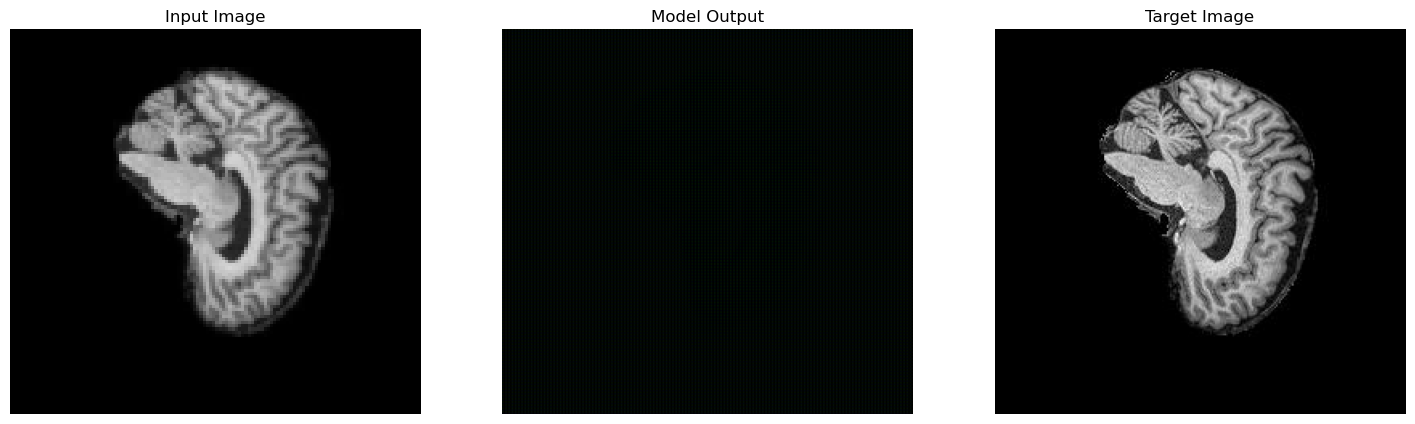

In [23]:
def save_model_output(prefix: str):
    with torch.no_grad():
        for expected_outputs, _ in data_loader:
                inputs = downsample_tensor(expected_outputs)
                
                # Get the dimensions of the first input image
                first_input_image = inputs[0]
                
                # Get the dimensions of the first output image
                first_output_image = expected_outputs[0]

                # Actual model output
                first_model_output = model(first_input_image)
                # Scale output to be in correct RGB range
                first_model_output = torch.clamp(first_model_output, 0, 1.0)
                
                # Display the first input image
                plt.figure(figsize=(18, 6))
                plt.subplot(1, 3, 1) # first column
                # Convert tensor to numpy format (C, H, W) -> (H, W, C)
                input_img_formatted = first_input_image.permute(1, 2, 0)
                plt.imshow(input_img_formatted)
                plt.title("Input Image")
                plt.axis('off')  # Turn off axis labels
                
                # Display the first output image
                plt.subplot(1, 3, 3) # third column
                # Convert tensor to numpy format (C, H, W) -> (H, W, C)
                output_img_formatted = first_output_image.permute(1, 2, 0)
                plt.imshow(output_img_formatted)
                plt.title("Target Image")
                plt.axis('off')  # Turn off axis labels

                # Display the first model output
                plt.subplot(1, 3, 2) # second column
                # Convert tensor to numpy format (C, H, W) -> (H, W, C)
                output_img_formatted = first_model_output.permute(1, 2, 0)
                output_img_formatted = torch.clamp(output_img_formatted, 0, 1)
                plt.imshow(output_img_formatted)
                plt.title(f"Model Output")
                plt.axis('off')  # Turn off axis labels
                
                filename = image_dir + prefix + 'output.png'

                plt.savefig(filename)
                print("Saved model output to", filename)
                
                break  # Stop after the first batch to print/display only the first pair of images
save_model_output('test')

Starting training...
Saved model output to imgs/[1,10][0,169]output.png


KeyboardInterrupt: 

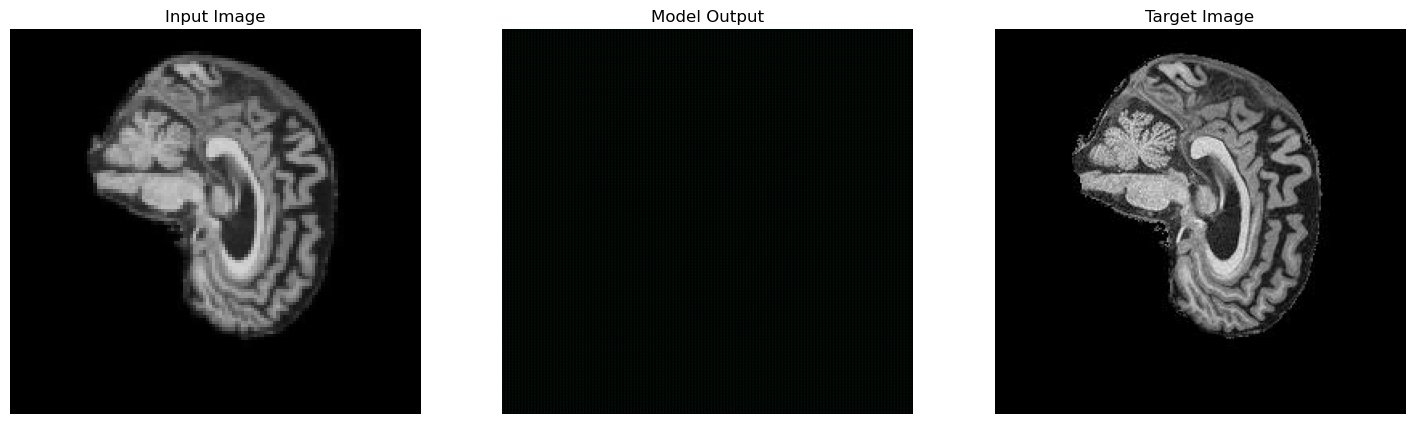

In [24]:
# Define the loss function (MSE) and optimizer (Adam)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

start = time.time()
print("Starting training...")
sys.stdout.flush()

n = len(data_loader)

save_model_output(f"[{1},{num_epochs}][{0},{n}]")


for epoch in range(num_epochs):
    running_loss = 0.0

    i = 0
    
    for expected_outputs, _ in data_loader:
        inputs = downsample_tensor(expected_outputs)
        
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Compute the loss
        loss = criterion(outputs, expected_outputs)

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        i += 1
        if i % 10 == 0 or i == 1:
            print(f"Finished [{i},{n}] loss: {loss.item()}")
            sys.stdout.flush()
        if i % 40 == 0 or (i == 1 and epoch == 0):
            save_model_output(f"[{epoch + 1},{num_epochs}][{i},{n}]")
            sys.stdout.flush()

    # Print the average loss for the epoch
    average_loss = running_loss / len(data_loader)
    print(f"Epoch [{epoch + 1},{num_epochs}] Loss: {average_loss:.4f}")
    sys.stdout.flush()

end = time.time()
print(f"Training finished. Took {round((end - start) / 60, 1)} minutes")
sys.stdout.flush()

In [ ]:
# Save the trained model to a file
model_path = "super_resolution_model.pth"
torch.save(model.state_dict(), model_path)

print(f"Model saved to {model_path}")

Model saved to super_resolution_model.pth


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


FileNotFoundError: [Errno 2] No such file or directory: 'imgs/[10/10][169/169]input-target-output.png'

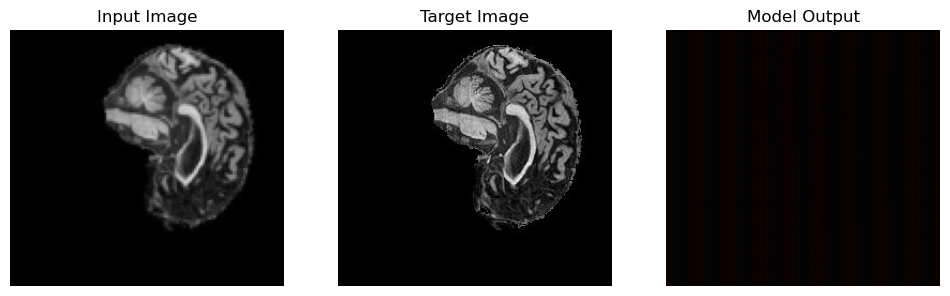

In [ ]:
save_model_output(f"[{num_epochs},{num_epochs}][{n},{n}]")
print("Finished!")